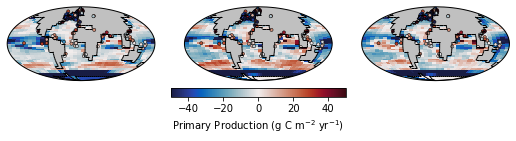

In [29]:
from cgeniepy.core import GenieModel
from cgeniepy.plot import plot_genie, scatter_on_genie
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import cmocean

def dEP(lgm_path, hol_path, var):

    hol = GenieModel(hol_path)
    lgm =  GenieModel(lgm_path)

    ## ecogem
    if var=='PP':
        diff = lgm.select_var("eco2D_Uptake_Fluxes_C") - hol.select_var("eco2D_Uptake_Fluxes_C")
        # mmol C m-3 d-1 to g C m-2 yr-1
        diff.array = diff.array * 12 / 1000 * 80.8 * 365
        diff.unit = r"Primary Production anamolies (g C m$^{-2}$ yr$^{-1}$)"
    elif var == 'POC':
        diff = lgm.select_var("bio_export_POC") - hol.select_var("bio_export_POC")        
        diff.array = diff.array * 12
        diff.unit = r"POC Export anamolies (g C m$^{-2}$ yr$^{-1}$)"
    elif var == "EP":
        diff = lgm.select_pft(var="export") - hol.select_pft(var="export")
        diff.array = diff.array * 12 / 1000 * 80.8 * 365
        diff.unit = r"Export Production anamolies (g C m$^{-2}$ yr$^{-1}$)"

    return diff

vmax=50
vmin=-50


ha = pd.read_csv("../data/LGM_productivity/Hernandez-Almeida_etal_2019_anomaly.csv")
ha = ha.rename({"anomaly(mg_C/m2/day)": "anomaly"}, axis=1)
ha['anomaly'] = ha['anomaly'] / 1000 * 365
ha = ha[['Longitude', "Latitude", "anomaly"]]

# gC m-2 yr-1
radi = pd.read_csv("../data/LGM_productivity/Radi_etal_2008.csv")
radi = radi.rename({"anomalies(gC/m2/yr)": "anomaly"}, axis=1)
radi = radi[['Longitude', "Latitude", "anomaly"]]

# merge datasets
df = pd.concat([ha, radi])

#fig, axes = plt.subplots(nrows=2, ncols=2,
#                         figsize=(5, 3.5),
#                         subplot_kw=dict(projection=ccrs.Mollweide()))

#config_lst = ['8P8Z', 'NPD', 'fixPFe','NPD_fixPFe']

fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(9, 3.5),
                         subplot_kw=dict(projection=ccrs.Mollweide()))
config_lst = ['8P8Z', "diat.Aaron23", "nodiat.Aaron23"]

for i,ax in enumerate(axes.flat):
    # row index
    config = config_lst[i]
    # first column: NPP
    diff = dEP(f"../model/LGM_{config}", f"../model/Hol_{config}", 'PP')
    p = plot_genie(ax, data=diff.array, vmin=vmin, vmax=vmax, cmap = "cmo.balance")
    p2 = scatter_on_genie(ax, df, "anomaly", vmin=vmin, vmax=vmax, cmap="cmo.balance", s=10)

cbar = fig.colorbar(p, ax=axes.flatten(), orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label(r"Primary Production (g C m$^{-2}$ yr$^{-1}$)", fontsize=10)

fig.savefig("../output/LGM_dNPP.jpg", dpi=300)

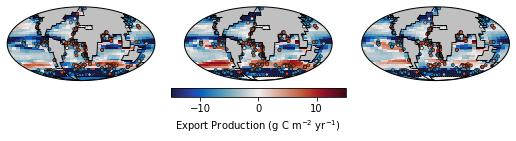

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(9, 3.5),
                         subplot_kw=dict(projection=ccrs.Mollweide()))

#config_lst = ['8P8Z', 'NPD', 'fixPFe','NPD_fixPFe']
config_lst = ['8P8Z', "diat.Aaron23", "nodiat.Aaron23"]

vmax=15
vmin=-15

obs = pd.read_csv("../data/LGM_productivity/combined_data.csv")
obs['Productivity_anomlies'] = obs['Productivity_anomlies'] * vmax/2

for i,ax in enumerate(axes.flat):
    # row index
    config = config_lst[i]
    # first column: NPP
    diff = dEP(f"../model/LGM_{config}", f"../model/Hol_{config}", 'EP')
    p = plot_genie(ax, data=diff.array, vmin=vmin, vmax=vmax, cmap = "cmo.balance")
    p2 = scatter_on_genie(ax, obs, "Productivity_anomlies", vmin=vmin, vmax=vmax, cmap = "cmo.balance", s=10)

cbar = fig.colorbar(p, ax=axes.flatten(), orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label(r"Export Production (g C m$^{-2}$ yr$^{-1}$)", fontsize=10)
fig.savefig("../output/LGM_dEP.jpg", dpi=300)

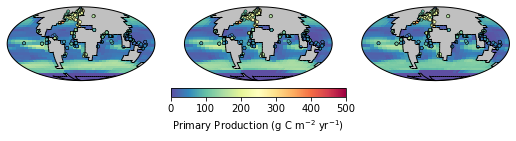

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(9, 3.5),
                         subplot_kw=dict(projection=ccrs.Mollweide()))

config_lst = ['8P8Z', "diat.Aaron23", "nodiat.Aaron23"]

# gC m-2 yr-1
radi = pd.read_csv("../data/LGM_productivity/Radi_etal_2008.csv")
radi = radi.rename({"Water_depth": "Depth (m)", "LGM": "NPP"}, axis=1)
radi = radi.drop(columns=['Modern', 'anomalies(gC/m2/yr)'])

# mgC m-2 d-1 to gC m-2 yr-1
ha = pd.read_csv("../data/LGM_productivity/Hernandez-Almeida_etal_2019_raw.csv")
ha = ha[ha['Time period'] == 'LGM']
ha = ha[ha['Latitude (N)'].abs() <= 30]
ha = ha.rename({"Latitude (N)": "Latitude", "Longitude (E)": "Longitude"}, axis=1)
ha['NPP'] = ha['NPP(mg C/m2/day)'] / 1000 * 365

df = pd.concat([ha, radi])

vmax=500
vmin=0

for i,ax in enumerate(axes.flat):
    # row index
    config = config_lst[i]
    # first column: NPP
    model = GenieModel(f"../model/LGM_{config}").select_var("eco2D_Uptake_Fluxes_C")
    model.array = model.array * 12 / 1000 * 80.8 * 365
    
    p = plot_genie(ax, data=model.array, vmin=vmin, vmax=vmax)
    p2 = scatter_on_genie(ax, df, "NPP", vmin=vmin, vmax=vmax, s=10)

cbar = fig.colorbar(p, ax=axes.flatten(), orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label(r"Primary Production (g C m$^{-2}$ yr$^{-1}$)", fontsize=10)
fig.savefig("../output/LGM_NPP(abs).jpg", dpi=400)

In [32]:
config_lst = ['8P8Z', "diat.Aaron23", "nodiat.Aaron23"]
for i in range(3):
    config = config_lst[i]
    model = GenieModel(f"../model/Hol_{config}").select_var("eco2D_Uptake_Fluxes_C")
    # mmol C m-3 d-1 to Gt C
    model.array = model.array * 12 / 1000 * model.marine_volume() * 1E9 * 1E-15 * 365
    print(model.nansum())

25.605260288761016
26.13973241124776
25.987068329489198


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xarray/core/variable.py:252: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xarray/core/variable.py:252: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xarray/core/variable.py:252: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


# Export Production (qualitative) score

In [19]:
# regrid data
import pandas as pd
from cgeniepy.grid import regrid_dataframe, GENIE_lat, normal_lon
from cgeniepy.scores import cal_corr, cal_crmse
import numpy as np

#read data
obs = pd.read_csv("../data/LGM_productivity/combined_data.csv")
obs = obs.rename({"Productivity_anomlies": "Observation"}, axis='columns')
obs = regrid_dataframe(obs)
obs = obs.values

def discrete_data(x, mid=3, large=10):
    if np.isnan(x):
        return 9999
    elif x >= mid and x < large:
        # [mid, large)    
        return 0.5
    elif x >= large:
        #[large, )    
        return 1
    elif x < large * -1:
        #[, -large)
        return -1
    elif x < mid * -1 and x >= large * -1:
        #[-large, -mid)
        return -0.5
    elif x > mid * -1 and x < mid:
        # [-mid, mid)    
        return 0
    else:
        print("wrong")

mod_l = ["8P8Z", "NPD", "fixPFe", "NPD_fixPFe", "8P", "1P1Z", "biogem", "diat.Aaron23", "nodiat.Aaron23"]

for i in mod_l:
    # model dEP
    diff = dEP(f'../model/LGM_{i}', f"../model/Hol_{i}", "POC")
    # reassign to normal longitude and convert to discrete data
    m = diff.reassign_array().apply(f=discrete_data).array
    # convert 9999 back to nan
    m  = np.where(m==9999,np.nan,m)

    print(cal_crmse(obs, m), i)

0.7556203624647139 8P8Z
0.8072654061964912 NPD
0.7524636569253548 fixPFe
0.8454646287426526 NPD_fixPFe
0.8664529669350729 8P
0.8371108872460548 1P1Z
0.8079885597436248 biogem
0.7532429329214674 diat.Aaron23
0.7547816841362391 nodiat.Aaron23


# dNPP scores

In [22]:
# mgC m-2 d-1
ha = pd.read_csv("../data/LGM_productivity/Hernandez-Almeida_etal_2019_anomaly.csv")
ha = ha.rename({"anomaly(mg_C/m2/day)": "anomaly"}, axis=1)
ha['anomaly'] = ha['anomaly'] / 1000 * 365
ha = ha[['Longitude', "Latitude", "anomaly"]]

# gC m-2 yr-1
radi = pd.read_csv("../data/LGM_productivity/Radi_etal_2008.csv")
radi = radi.rename({"anomalies(gC/m2/yr)": "anomaly"}, axis=1)
radi = radi[['Longitude', "Latitude", "anomaly"]]

# merge datasets
df = pd.concat([ha, radi])

obs = df.rename({"anomaly": "Observation"}, axis='columns')
obs = regrid_dataframe(obs)
obs = obs.values

mod_l = ["8P8Z", "NPD", "fixPFe", "NPD_fixPFe", "8P", "1P1Z", "diat.Aaron23", "nodiat.Aaron23"]

for i in mod_l:
    # model dEP
    diff = dEP(f'../model/LGM_{i}', f"../model/Hol_{i}", "PP")
    # reassign to normal longitude
    m = diff.reassign_array().array
    # convert 9999 back to nan
    m  = np.where(m==9999,np.nan,m)

    print(cal_crmse(obs, m), i)

3487.30296656295 8P8Z
4542.700097373154 NPD
3820.5555579257843 fixPFe
3227.687652734981 NPD_fixPFe
3085.343443662099 8P
3913.1176931779046 1P1Z
2523.6478439806524 diat.Aaron23
2797.017082856851 nodiat.Aaron23


# NPP in LGM scores

In [24]:
# gC m-2 yr-1
radi = pd.read_csv("../data/LGM_productivity/Radi_etal_2008.csv")
radi = radi.rename({"Water_depth": "Depth (m)", "LGM": "NPP"}, axis=1)
radi = radi.drop(columns=['Modern', 'anomalies(gC/m2/yr)'])

# mgC m-2 d-1 to gC m-2 yr-1
ha = pd.read_csv("../data/LGM_productivity/Hernandez-Almeida_etal_2019_raw.csv")
ha = ha[ha['Time period'] == 'LGM']
ha = ha[ha['Latitude (N)'].abs() <= 30]
ha = ha.rename({"Latitude (N)": "Latitude", "Longitude (E)": "Longitude"}, axis=1)
ha['NPP'] = ha['NPP(mg C/m2/day)'] / 1000 * 365

df = pd.concat([ha, radi])

obs = df.rename({"NPP": "Observation"}, axis='columns')
obs = regrid_dataframe(obs)
obs = obs.values

mod_l = ["8P8Z", "NPD", "fixPFe", "NPD_fixPFe", "8P", "1P1Z", "diat.Aaron23", "nodiat.Aaron23"]

for i in mod_l:
    # model dEP
    diff = GenieModel(f'../model/LGM_{i}').select_var("eco2D_Uptake_Fluxes_C")
    diff.array = diff.array * 12 / 1000 * 80.8 * 365
    # reassign to normal longitude
    m = diff.reassign_array().array
    # convert 9999 back to nan
    m  = np.where(m==9999,np.nan,m)

    print(cal_crmse(obs, m), i)

4400.11920024579 8P8Z
3002.0018062335903 NPD
4739.323562937447 fixPFe
2995.3698468482417 NPD_fixPFe
4949.832757168782 8P
4645.277521721411 1P1Z
5628.003198735074 diat.Aaron23
5582.6390611901115 nodiat.Aaron23
